In [1]:
import os
from typing import Dict, NamedTuple, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
class Config(NamedTuple):
    data: str = "../preliminary.csv"
    dirctory: str = "../images/dataviz"
    savefile: bool = False
    kwarg_savefig: Dict[str, Union[str, int, float]] = {
        "facecolor": "white",
        "dpi": 300,
        "bbox_inches": "tight",
        "pad_inches": 0.05
    }

In [3]:
conf = Config(savefile=True)

In [4]:
os.makedirs(conf.dirctory, exist_ok=True)

In [5]:
# load result data

res = pd.read_csv(conf.data, index_col=0)
res

,1.0,1.5,2.0,2.5,2.97
Num of trial,,,,,
0,4.94,5.68,5.13,6.55,5.36
1,5.22,5.67,5.81,4.81,5.34
2,4.14,5.72,6.83,7.10,6.10
3,5.46,6.04,5.59,6.73,5.62
4,5.18,6.23,6.28,8.21,5.50


In [6]:
# reshape res matrix

batch = pd.Series([i // 5 + 1 for i in np.arange(25)])
size = pd.Series([1, 1.5, 2, 2.5, 2.97]*5)

df = pd.DataFrame(res.values.reshape(-1, 1), columns=["time"]).assign(batch=batch, size=size)

In [7]:
df.head(6)

,time,batch,size
0,4.94,1,1.00
1,5.68,1,1.50
2,5.13,1,2.00
3,6.55,1,2.50
4,5.36,1,2.97
5,5.22,2,1.00


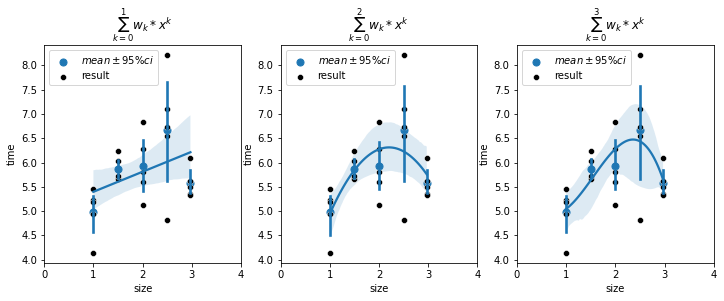

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for idx, subplot in enumerate(ax):
    sns.regplot(data=df, x="size", y="time", x_estimator=np.mean, order=idx+1, ax=subplot, x_ci=95, label="$mean \pm 95$"+"%"+"$ci$")
    sns.scatterplot(data=df, x="size", y="time", color="k", ax=subplot, label="result")
    subplot.set_xlim([0, 4])
    title = "$\sum_{k=0}" + f"^{idx+1}" + "w_k * x^k$"
    subplot.set(title=title)
    subplot.legend()
    
if conf.savefile:
    plt.savefig(f"{conf.dirctory}/size.png", **conf.kwarg_savefig)

In [9]:
l_x = [
    sm.add_constant(np.log(df.loc[:, "size"])),
    sm.add_constant(np.log(df.loc[:, "batch"]))
]
y = np.log(df.loc[:, "time"])

params = [sm.OLS(y, x).fit().params for x in l_x]

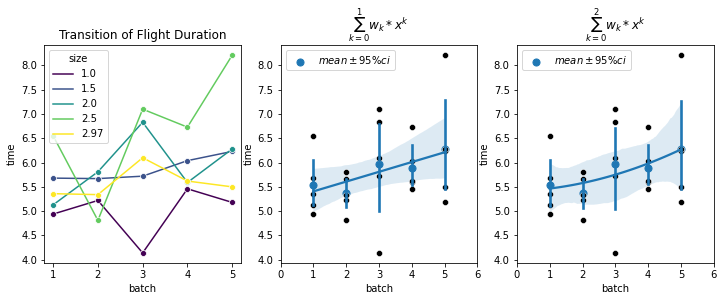

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

sns.lineplot(data=df, x="batch", y="time", hue="size", ax=ax[0], palette="viridis", marker="o")
ax[0].set(title="Transition of Flight Duration")

for idx, subplot in enumerate(ax[1:]):
    subplot.set_xlim([0, 6])
    sns.regplot(data=df, x="batch", y="time", x_estimator=np.mean, order=idx+1, ax=subplot, x_ci=95, label="$mean \pm 95$"+"%"+"$ci$")
    sns.scatterplot(data=df, x="batch", y="time", color="k", ax=subplot)
    title = "$\sum_{k=0}" + f"^{idx+1}" + "w_k * x^k$"
    subplot.set(title=title)
    subplot.legend()
    
if conf.savefile:
    plt.savefig(f"{conf.dirctory}/batch.png", **conf.kwarg_savefig)

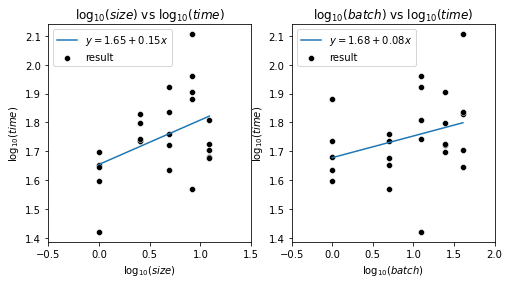

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

for i, x in enumerate(l_x):
    x_range = np.linspace(x.iloc[:, -1].min(), x.iloc[:, -1].max(), 1000)
    
    ax[i].set_xlim([-0.5, np.ceil(x.iloc[:, -1].max() / 0.5) * 0.5])
    label = "$y=" + f"{params[i][0].round(2)}" + "+" + f"{params[i][1].round(2)}" + "x$"
    xlabel = "$\log_{10}(" + f"{('size', 'batch')[i]}" + ")$"
    ylabel = "$\log_{10}(time)$"
    title = f"{xlabel} vs {ylabel}"
    ax[i].plot(
        x_range, params[i][0] + params[i][1] * x_range, label=label, alpha=1
    )
    sns.scatterplot(x=x.iloc[:, -1], y=y, ax=ax[i], color="k", label="result")
    ax[i].set(xlabel=xlabel, ylabel=ylabel, title=title)
    ax[i].legend()
    
if conf.savefile:
    plt.savefig(f"{conf.dirctory}/log_log.png", **conf.kwarg_savefig)